In [3]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from numba import njit

%matplotlib inline

## Исходная функция

In [4]:
df = pd.DataFrame({
    'x': np.arange(0, 1.05, 0.15),
    'y': [1.000000, 0.838771, 0.655336, 0.450447, 0.225336, -0.018310, -0.278390, -0.552430],
    'y`': [-1.000000, -1.14944, -1.29552, -1.43497, -1.56464, -1.68164, -1.78333, -1.86742],
})

df

,x,y,y`
0,0.00,1.000000,-1.00000
1,0.15,0.838771,-1.14944
2,0.30,0.655336,-1.29552
3,0.45,0.450447,-1.43497
4,0.60,0.225336,-1.56464
5,0.75,-0.018310,-1.68164
6,0.90,-0.278390,-1.78333
7,1.05,-0.552430,-1.86742


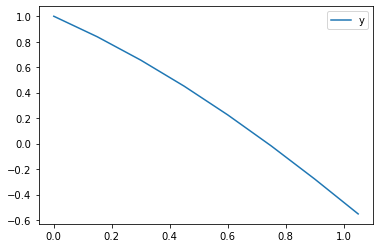

In [82]:
plt.plot(df['x'], df['y'], label='y')
# plt.plot(df['x'], df['y`'], label='y`')
plt.legend()
plt.show()

## Newton

In [83]:
def y(zs, xs, ys, cache):
    """
    Вычисление функции y.
    Params:
        zs: агрументы y(z1, z2, ..., zn)
        xs: аргументы исходной функции
        ys: значения исзодной функции
    Returns:
        значение функции y(z1, z2, ..., zn)
    """
    if len(zs) == 1:
        point = zs[0]
        index = xs.index(point)
        return ys[index]
    else:
        if zs in cache:
            return cache[zs]
        starting_points, end = zs[:-1], zs[-1]
        start, ending_points = zs[0], zs[1:]
        res = (y(starting_points, xs, ys, cache) - y(ending_points, xs, ys, cache)) / (start - end)
        cache[zs] = res
        return res
    

In [84]:
def newton(x, n, xs, ys):
    """
    Params:
        x: точка в которой ищем значение
        n: степерь полинома
        xs: подмножество аргуметов x, значения которых мы имеем
    Returns:
        Значение y в искомой точке
    """
    x_0 = (xs[0], )
    cache = {}
    result = y(x_0, xs, ys, cache)
    for k in range(1, n):
        product = 1
        for x_i in xs[0:k]:
            product *= (x - x_i)

        y_res = y(tuple(xs[0:k+1]), xs, ys, cache)
        product *= y_res
        result += product
    return result


In [91]:
df['x'].min()

0.0

In [85]:
x_0 = 0.525
comparison = {"x": [], "n": [], "newton":[]}

for n in range(1, 7):
    result = newton(x_0, n, df['x'].to_list(), df['y'].to_list())
    comparison['x'].append(x_0)
    comparison['n'].append(n)
    comparison['newton'].append(result)

comparison = pd.DataFrame(comparison)
comparison

,x,n,newton
0,0.525,1,1.000000
1,0.525,2,0.435699
2,0.525,3,0.338547
3,0.525,4,0.340192
4,0.525,5,0.340323
5,0.525,6,0.340324


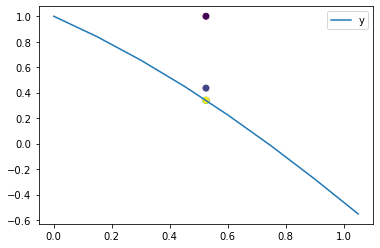

In [86]:
plt.plot(df['x'], df['y'], label='y')
plt.scatter(comparison['x'], comparison['newton'], c=comparison['n'])
plt.legend()
plt.show()

## Hermite

In [87]:
LOOKUP_TABLE = np.array([
    1, 1, 2, 6, 24, 120, 720, 5040, 40320,
    362880, 3628800, 39916800, 479001600,
    6227020800, 87178291200, 1307674368000,
    20922789888000, 355687428096000, 6402373705728000,
    121645100408832000, 2432902008176640000], dtype='int64')

@njit
def fast_factorial(n):
    if n > 20:
        raise ValueError
    return LOOKUP_TABLE[n]

In [89]:
@njit
def is_derivative(zs):
    for z in zs:
        if abs(z - zs[0]) > 0.001:
            return False
    return True

@njit
def look_up_derivative(zs, xs, y_derivatives):
    m = len(zs)
    fact = fast_factorial(m-1)
    index = xs.index(zs[0])
    derivative = y_derivatives[m-1][index]
    return derivative / fact


def y_with_lookup(zs, xs, y_derivatives, cache):
    """
    Вычисление функции y.
    Params:
        zs: агрументы y(z1, z2, ..., zn)
        xs: аргументы исходной функции
        ys: значения исзодной функции
    Returns:
        значение функции y(z1, z2, ..., zn)
    """
    derivative_is_in_table = len(zs) <= y_derivatives.shape[0]
    if is_derivative(zs) and derivative_is_in_table:
        return look_up_derivative(zs, xs, y_derivatives)
    else:

        if zs in cache:
            return cache[zs]

        starting_points, end = zs[:-1], zs[-1]
        start, ending_points = zs[0], zs[1:]
        res = (y_with_lookup(starting_points, xs, y_derivatives, cache) -
                y_with_lookup(ending_points, xs, y_derivatives, cache)) \
                / (start - end)
        cache[zs] = res
        return res

def hermite(x, xs, y_derivatives):
    n = y_derivatives.size - 1
    x_0 = [xs[0]]
    cache = dict()
    result = y_with_lookup(tuple(x_0), xs, y_derivatives, cache)

    for k in range(1, n):
        product = 1
        for x_i in xs[0:k]:
            product *= (x - x_i)
        product *= y_with_lookup(tuple(xs[0:k+1]), xs, y_derivatives, cache)
        result += product
    return result, cache


x_0 = 0.525
comparison = {"x": [], "n": [], "hermite":[]}
y_derivatives = np.array([
    df['y'],
    df['y`']
])

result, cache = hermite(x_0, tuple(df['x']), y_derivatives)
comparison['x'].append(x_0)
comparison['n'].append(0)
comparison['hermite'].append(result)

comparison = pd.DataFrame(comparison)
comparison

,x,n,hermite
0,0.525,0,0.340324


In [14]:
x = df['x'].values
x = np.repeat(x, 3)
x

array([0.  , 0.  , 0.  , 0.15, 0.15, 0.15, 0.3 , 0.3 , 0.3 , 0.45, 0.45,
       0.45, 0.6 , 0.6 , 0.6 , 0.75, 0.75, 0.75, 0.9 , 0.9 , 0.9 , 1.05,
       1.05, 1.05])

In [16]:
y_derivatives = np.array([
    df['y'].values.repeat(2),
    df['y`'].values.repeat(2)
])